## 2ª Parte

### Objetivo

Utilizando a biblioteca _OpenCV_, deve-se criar um algoritmo que possibilite a detecção e troca de _backgrounds_ de imagens que utilizam _chroma key_, ou seja, que possuem _background_ verde.

### Desenvolvimento do Algoritmo

#### Inicialização

Antes de tudo, é necessário importar as bibliotecas que serão utilizadas.

In [40]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

Além disso, são declaradas algumas constantes, sendo elas: caminho da imagem de entrada, caminho da imagem de _background_ e diretório onde a imagem de saída será salva.

In [41]:
INPUT_IMG_DIR = 'input/'
OUTPUT_IMG_DIR = 'output/'

INPUT_IMG_NAME = 'elefante.jpg'
BACKGROUND_IMG_NAME = 'background2.jpg'

É realizada a leitura da imagem de entrada, cujo _background_ será removido e substituído por outro.

A imagem de entrada é exibida através da biblioteca _Matplotlib_, apenas para confirmar se a leitura ocorreu corretamente. Observe que a imagem é convertida para o formato RGB antes de ser exibida. Isso acontece devido ao fato da biblioteca _OpenCV_ ler imagens e trabalhar com o formato BGR, embora o formato convencional seja o RGB. Como a _Matplotlib_ espera receber as imagens neste formato convencional, é necessário realizar a conversão. Portanto, sempre que uma imagem for ser exibida, ao longo deste documento, a conversão para RGB acontecerá antes.

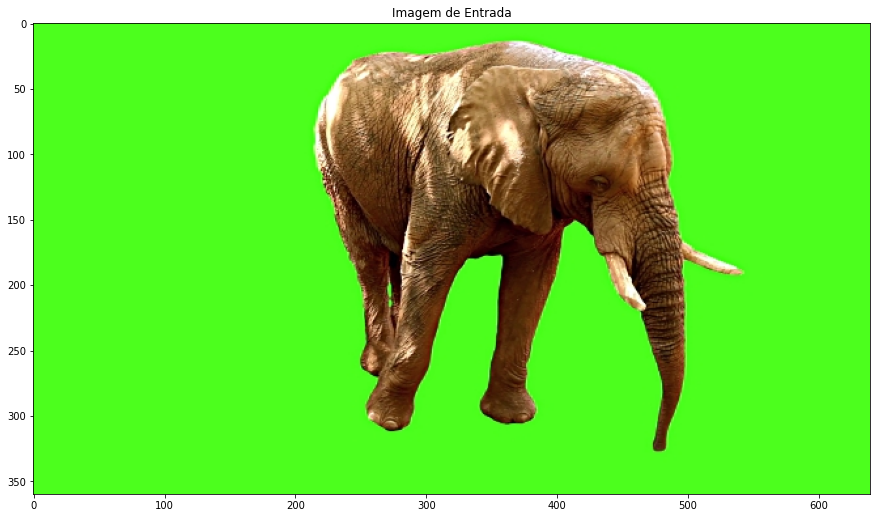

In [42]:
input_img = cv2.imread(INPUT_IMG_DIR + INPUT_IMG_NAME)

plt.figure(figsize=(15, 15))
plt.title('Imagem de Entrada')
plt.imshow(cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB))
plt.show()

#### Remoção do _background_

Para atingir-se o objetivo proposto, uma das etapas essenciais é a identificação do intervalo de cores verdes que fazem parte do _background_ da imagem. Para isso, o formato ideal de cores a ser utilizado é o HSV, em vez do BGR/RGB. Logo, é realizada a conversão da imagem para o formato HSV.

A identificação do intervalo de cores verdes é realizada através da análise de histogramas. Cada histograma deverá conter a informação de apenas um dos canais de cores do HSV. Por isso, cada um dos canais é obtido individualmente, sendo eles: H (_Hue_), S (_Saturation_) e V (_Value_).

In [43]:
hsv_input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2HSV)
h_channel, s_channel, v_channel = cv2.split(hsv_input_img)

Utilizando a biblioteca _NumPy_, os dados de cada canal de cor são processados e utilizados na geração de histogramas.

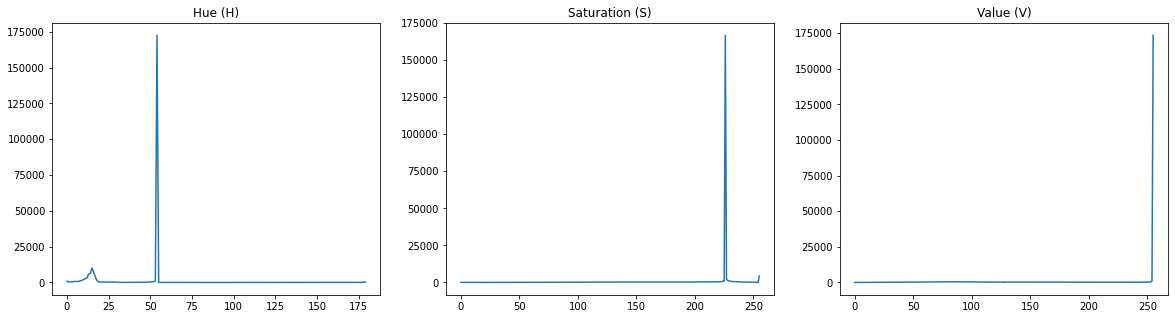

In [44]:
def generate_numpy_histogram(values, bins=256):
  histogram, _ = np.histogram(values, bins)
  return histogram

plt.figure(figsize=[20, 5])

plt.subplot(131)
plt.plot(generate_numpy_histogram(h_channel, 180))
plt.title('Hue (H)')

plt.subplot(132)
plt.plot(generate_numpy_histogram(s_channel))
plt.title('Saturation (S)')

plt.subplot(133)
plt.plot(generate_numpy_histogram(v_channel))
plt.title('Value (V)')

plt.show()

Através da análise dos histogramas acima, é possível observar certos valores que ocorrem centenas de milhares de vezes (observe os picos e os valores próximos a eles). Essas valores são justamente das cores do _background_ da imagem de entrada.

Embora pareça, o _background_ da imagem de entrada não é heterogêneo, mas sim composto de diversas cores semelhantes, com pequenas variações de tons. Devido a isso, não é correto remover da imagem apenas a cor que mais ocorre nos histogramas, mas sim utilizar um intervalo de cores próximas à ela. O intervalo que encontrou-se como ideal para a remoção do _background_ verde está definido entre os seguintes valores:

- No canal H: entre 40 e 75, por englobar quase todos os valores de matiz (_hue_) que possibilitam representar a cor verde. Observe que 40 é 80° e 75 é 150° no formato convencional do HSV;
- No canal S: entre 100 e 256, por englobar diversas saturações/tons de verde diferentes;
- No canal V: entre 20 e 256, por englobar diversos valores de brilho para os tons de verde.

Observe que esses valores não foram obtidos apenas a partir dos histogramas da imagem de entrada atual, mas sim a partir da análise dos histogramas de diversas imagens que utilizam _chroma key_.

Definido esses valores para os intervalos, são geradas duas máscaras binárias através do _OpenCV_.

In [45]:
lower_boundary = np.array([40, 100, 20])
upper_boundary = np.array([75, 256, 256])

mask = cv2.inRange(hsv_input_img, lower_boundary, upper_boundary)
inverted_mask = cv2.bitwise_not(mask)

Abaixo são exibidas gráficamente as duas máscaras binárias obtidas. A primeira será utilizada para remover o _background_ da imagem (observe que somente há valor na parte branca, correspondente ao _background_). A segunda será utilizada para selecionar o conteúdo "real" da imagem, ou seja, o que não faz parte do _background_.

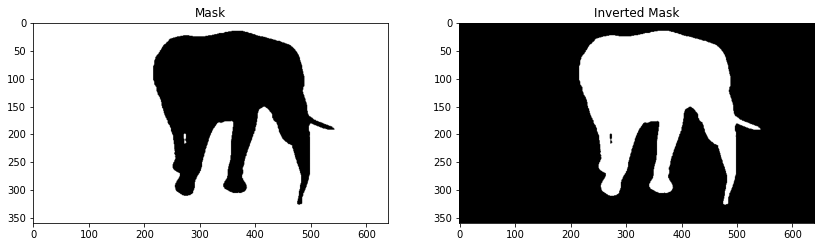

In [46]:
plt.figure(figsize=[14, 5])

plt.subplot(121)
plt.imshow(mask, cmap='gray')
plt.title('Mask')

plt.subplot(122)
plt.imshow(inverted_mask, cmap='gray')
plt.title('Inverted Mask')

plt.show()

Utilizando a segunda máscara e operações bit-a-bit, obtém-se uma cópia da imagem, porém sem o _background_ verde.

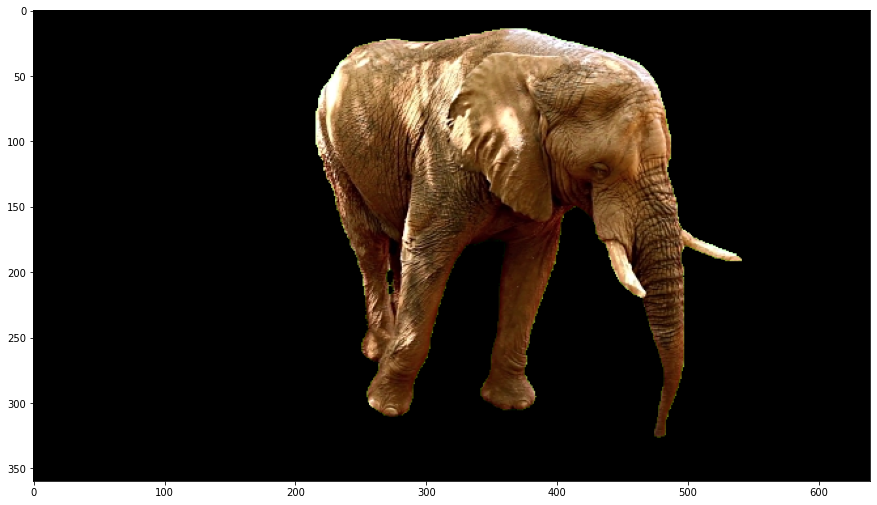

In [47]:
masked_hsv_img = cv2.bitwise_and(hsv_input_img, hsv_input_img, mask=inverted_mask)

plt.figure(figsize=(15, 15))
plt.imshow(cv2.cvtColor(masked_hsv_img, cv2.COLOR_HSV2RGB))
plt.show()

#### Inserção do novo _background_

De posse das máscaras binárias e da imagem de entrada sem o _background_ verde, agora é necessário somente inserir o novo _background_ na imagem.

Abaixo a imagem de _background_ é lida e convertida para o formato HSV.

In [48]:
background_img = cv2.imread(INPUT_IMG_DIR + BACKGROUND_IMG_NAME)
hsv_background_img = cv2.cvtColor(background_img, cv2.COLOR_BGR2HSV)

Como as dimensões da imagem do novo _background_ nem sempre serão as mesmas da imagem de entrada, é necessário redimensionar o novo _background_ para as mesmas dimensões da imagem de entrada. Esse redimensionamento é realizado de forma que a proporção da imagem seja mantida, para que não fique distorcida.

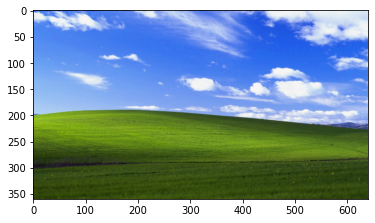

In [49]:
input_img_height = input_img.shape[0]
input_img_width = input_img.shape[1]
background_img_height = background_img.shape[0]
background_img_width = background_img.shape[1]

aspect_ratio = input_img_height / background_img_height
new_background_height = int(background_img_height * aspect_ratio)
new_background_size = (input_img_width, new_background_height)

hsv_background_img = cv2.resize(hsv_background_img, new_background_size, interpolation=cv2.INTER_AREA)

plt.imshow(cv2.cvtColor(hsv_background_img, cv2.COLOR_HSV2RGB))
plt.show()

Utilizando a primeira máscara binária gerada anteriormente, é gerado o novo _background_ para a imagem, através de operações bit-a-bit.

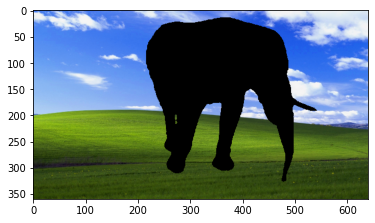

In [50]:
new_img_background = cv2.bitwise_and(hsv_background_img, hsv_background_img, mask=mask)

plt.imshow(cv2.cvtColor(new_img_background, cv2.COLOR_HSV2RGB))
plt.show()

Por fim, a imagem final é gerada através da adição dos dados do novo _background_ e da cópia da imagem sem o _background_ verde.

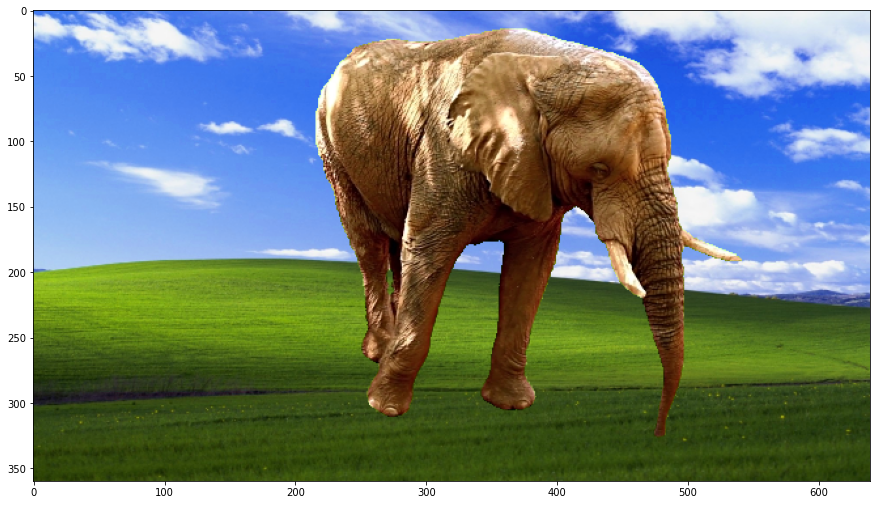

In [51]:
new_img = cv2.add(new_img_background, masked_hsv_img)

plt.figure(figsize=(15, 15))
plt.imshow(cv2.cvtColor(new_img, cv2.COLOR_HSV2RGB))
plt.show()

#### Salvamento da imagem final

A imagem final é salva na pasta de _output_, contendo as mesmas dimensões da imagem original de entrada, sem o _background_ verde e com um novo _background_ personalizado.

In [52]:
output_img_data = cv2.cvtColor(new_img, cv2.COLOR_HSV2BGR)
cv2.imwrite(OUTPUT_IMG_DIR + INPUT_IMG_NAME, output_img_data)

True

### Algoritmo Final

Todos os passos descritos anteriormente podem ser resumidos em um único algoritmo, para ser utilizado de maneira prática em quaisquer imagens desejadas.

O arquivo [background-swapper.py](./background-swapper.py) contém o algoritmo completo, sendo possível executá-lo através de seu terminal utilizando `python background-swapper.py <nome-da-imagem> <nome-do-background>`. O argumento `<nome-da-imagem>` trata-se do nome da imagem cujo _background_ verde será removido, enquanto o argumento `<nome-do-background>` trata-se do nome da imagem que servirá de novo _background_. Ambos argumentos são obrigatórios e os arquivos das imagens devem estar dentro da pasta `input`. A imagem de saída gerada pelo algoritmo será armazenada na pasta `output` com o mesmo nome da imagem de entrada.

Exemplo de execução do algoritmo: `python background-swapper.py elefante.jpg background2.jpg` .